In [139]:
###LIBRERIE 
import numpy as np 
import pandas as pd 
import os
import keras
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.python.client import device_lib
from PIL import Image
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from keras import layers, models
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam, RMSprop

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())


['/device:CPU:0', '/device:XLA_CPU:0', '/device:XLA_GPU:0']


In [140]:
###DATA PREPROCESSING 
folder_benign_train = "C:\\Users\\Piermarco\\Documents\\ML\\Tumori-benigni-maligni\\train\\benign"
folder_malignant_train = "C:\\Users\\Piermarco\\Documents\\ML\\Tumori-benigni-maligni\\train\\malignant"

folder_benign_test = "C:\\Users\\Piermarco\\Documents\\ML\\Tumori-benigni-maligni\\train\\benign"
folder_malignant_test = "C:\\Users\\Piermarco\\Documents\\ML\\Tumori-benigni-maligni\\train\\malignant"

read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

# Carico le immagini di train
ims_benign = [read(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array(ims_malignant, dtype='uint8')

# Carico le immagini di test
ims_benign = [read(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array(ims_malignant, dtype='uint8')

In [141]:
#Creo la Labals mancanti per sapere se sono maligni 1 se sono benigni 0 
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])


In [142]:
#Faccio una merge dei dati dei tumori benigni e maligni
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

#Shuffle
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

In [143]:
#Controllo sulle dimensione dei tensori 
X_train.shape
X_train.ndim

4

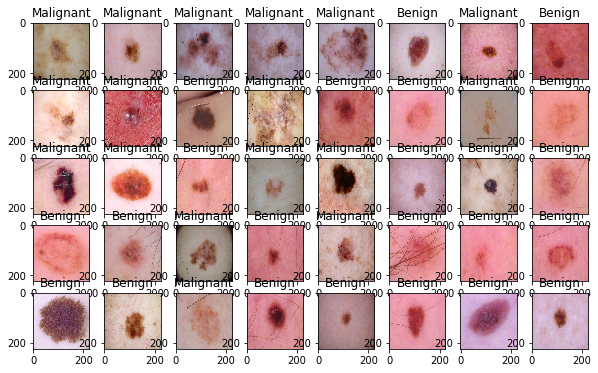

In [144]:
#Mostro immagini
fig=plt.figure(figsize=(10, 6))
columns = 8
rows = 5

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

In [145]:
###TRASFORMO IN LABLES CATEGORICHE
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test =tf.keras.utils.to_categorical(y_test, num_classes=2)
y_train.astype

<function ndarray.astype>

In [146]:
###NORMALIZZO TUTTE LE IMMAGINI
X_train = X_train/255
X_test = X_test/255
X_train.shape


(2637, 224, 224, 3)

In [147]:
#in optin da provare con rmsprop , adam e in activation_Dense con sigmoid , softmax
def Addestramento(input_shape, lr, numclassi, optim, activation_Dense): 
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))#metto questo stato di dropout per evitare un over fitting della rete 
    model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
    model.add(MaxPool2D(2,2))
    model.add(Dropout(0.25))
    model.add(layers.Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(numclassi, activation='softmax'))
    #Scegli l'ottimizzatore
    if optim == 'rmsprop':
        optimizer = RMSprop(lr=lr)
    else:
        optimizer = Adam(lr=lr)
    model.summary()

    model.compile(optimizer = optimizer ,loss = "binary_crossentropy", metrics=["accuracy"])
    return model

In [148]:
model = Addestramento((224,224,3), 1e-5, 2,'relu', 'adam')

epochs = 30
batch_size = 64
history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs= epochs , batch_size= batch_size, verbose=0)
                    # list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 54, 54, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 186624)          

KeyboardInterrupt: 